# EDA

In [3]:
# Data and libraries loading

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings; warnings.simplefilter('ignore')

raw = pd.read_csv('movie_metadata.csv', low_memory=False)
data = raw.copy()

### Data Cleaning

In [4]:
# Extraction of movie_id from imdb_link:
data['movie_id'] = data['movie_imdb_link'].apply(lambda string: string.split('/tt')[1].split('/')[0])

In [5]:
# Valeurs erronées: delete duplicates

data = data.drop_duplicates(subset='movie_imdb_link', keep = 'first')
data.shape

(4919, 29)

In [6]:
# Calling OMDb API from ID getting missing data (following fields available in the API):

L_fields = ['movie_title','movie_imdb_link','title_year','language','country',
            'director_name','actor_1_name','actor_2_name', 'actor_3_name']
L_index = []

for i in range(1,len(L_fields)+1):         
    # lignes ayant un champ vide parmi cette liste
    df = data.loc[:,L_fields[i-1]][(data.loc[:,L_fields[i-1]]).isnull()]
    L_index.extend(list( df.index )) # record indexes
L_index = list(set(L_index)) # suppression index en doublons
print(len(L_index),'lignes ont 1 champ vide au moins parmi cette liste')

134 lignes ont 1 champ vide au moins parmi cette liste


In [7]:
df = data.loc[L_index, L_fields].copy()

# Creation de l'URL via IMDb ID :
url1 = 'http://www.omdbapi.com/?i='
url3 = '&apikey=1ffba84e' #Personnal key obtained creating an account online - limited to 1000 daily requests
df['url'] = url1 + df['movie_imdb_link'].apply(lambda string: 'tt'+string.split('/tt')[1].split('/')[0]) + url3

# Utilisation API:
import requests
flag = 0

for index, row in df.iterrows():
    r = requests.get(row['url'])
    json_data = r.json()
    
    if ((row['director_name']=='') or (row['director_name']!=row['director_name'])) and (json_data['Director']!='N/A'):    
        data.loc[index,'director_name'] = json_data['Director']
        flag +=1
    if ((row['title_year']=='') or (row['title_year']!=row['title_year'])) and (json_data['Released']!='N/A'):    
        data.loc[index,'title_year'] = json_data['Released'][-4:]
        flag +=1
    if ((row['actor_1_name']=='') or (row['actor_1_name']!=row['actor_1_name'])) and (json_data['Actors']!='N/A'):
        data.loc[index,'actor_1_name'] = json_data['Actors'].split(',')[0]
        flag +=1
    if ((row['actor_2_name']=='') or (row['actor_2_name']!=row['actor_2_name'])) and (json_data['Actors']!='N/A'):
        if len(json_data['Actors'].split(','))>1:
            data.loc[index,'actor_2_name'] = json_data['Actors'].split(',')[1]
            flag +=1
    if ((row['actor_3_name']=='') or (row['actor_3_name']!=row['actor_3_name'])) and (json_data['Actors']!='N/A'):
        if len(json_data['Actors'].split(','))>2:
            data.loc[index,'actor_3_name'] = json_data['Actors'].split(',')[2]
            flag +=1
    if ((row['language']=='') or (row['language']!=row['language'])) and (json_data['Language']!='N/A'):
            data.loc[index,'language'] = json_data['Language']
            flag +=1
    if ((row['country']=='') or (row['country']!=row['country'])) and (json_data['Country']!='N/A'):
            data.loc[index,'country'] = json_data['Country']
            flag +=1
#     if ((row['duration']=='') or (row['duration']!=row['duration'])) and (json_data['Runtime']!='N/A'):
#         data.loc[index,'duration'] = float(json_data['Runtime'].replace('mn','').replace('min','').replace('Min','').replace('Mn','').rstrip())
#         flag +=1
            
print(flag,' cellules corrigées')

107  cellules corrigées


In [8]:
# Suppression des champs inutile dans la mesure de succès ou similarité d'un film:

data = data.drop(['duration',
                  'facenumber_in_poster',
                  'movie_imdb_link',
                  'aspect_ratio'], axis=1)

data.shape

(4919, 25)

In [9]:
# Suppression lignes vides pour title_year: # 4 lignes

data = data[data[['title_year']].notnull().all(axis=1)]
print(raw.shape[0]-data.shape[0],' lignes supprimées sur ',raw.shape[0]) 

data.shape

128  lignes supprimées sur  5043


(4915, 25)

In [10]:
# Correction: typage colonne de temps:

data['title_year'] = data['title_year'].astype(int)
data['title_year'] = pd.to_datetime(data['title_year'], format='%Y').dt.year

In [11]:
# Correction: remplacement NaN dans Colour: (10 lignes)

df1 = data[data['color'].isnull()][data['title_year']>=1955] #Films après 1955 à NaN--> color
df2 = data[data['color'].isnull()][data['title_year']<1955] # Films avant 1955 à NaN--> b&w
data['color'].loc[df1.index] = 'Color'

In [12]:
# Correction: remplacement NaN dans: 'language' lorsqu'on connait 'country' (10 lignes)

df1 = data[['language','country']][data['language'].isnull()]
for index, row in df1.iterrows():
    if row['country']=='USA':
        data.loc[index,'language'] = 'English'

# Suppression des NaN restant dans: 'language' et 'country' (2 lignes)

data = data[data['language'].notnull()]
data = data[data['country'].notnull()]

data.shape

(4911, 25)

In [13]:
# Correction: remplacement NaN par "" dans les champs 'string':

L = ['plot_keywords','director_name','actor_1_name','actor_2_name','actor_3_name','content_rating']
for string in L:
    data[string][data[string].isnull()] = ""

In [14]:
# Valeurs erronées: mêmes catégories appelées différemment:
data['content_rating'] = data['content_rating'].replace('Passed', 'Approved').replace('Unrated','Not Rated')

In [15]:
# Valeurs erronées: all lines of 'movie_title' contains unicode special characters:
display(data['movie_title'][0]) # example

# Data correction:
import unicodedata
for index in data['movie_title'].index:
    data['movie_title'][index] = unicodedata.normalize('NFKD', data['movie_title'][index])
    
display(data['movie_title'][0]) # example corrected

'Avatar\xa0'

'Avatar '

### Data Exploration

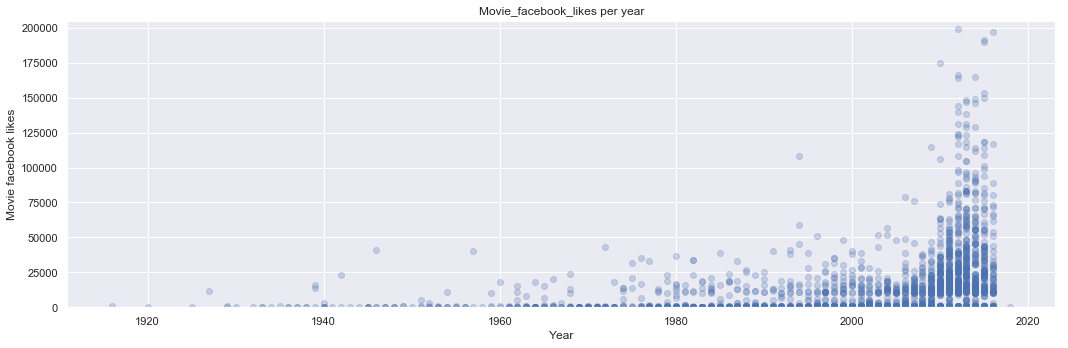

In [16]:
# Movie facebook likes VS Years:

plt.subplots(figsize=(15,5))
plt.scatter(data['title_year'],
            data['movie_facebook_likes'],
            alpha=0.25)
plt.ylim([0,205000]) #avoiding 1 outlier
plt.xlabel('Year')
plt.ylabel('Movie facebook likes')
plt.title('Movie_facebook_likes per year')
plt.tight_layout()
plt.show()

# ==> de plus en plus de likes sur les films récents

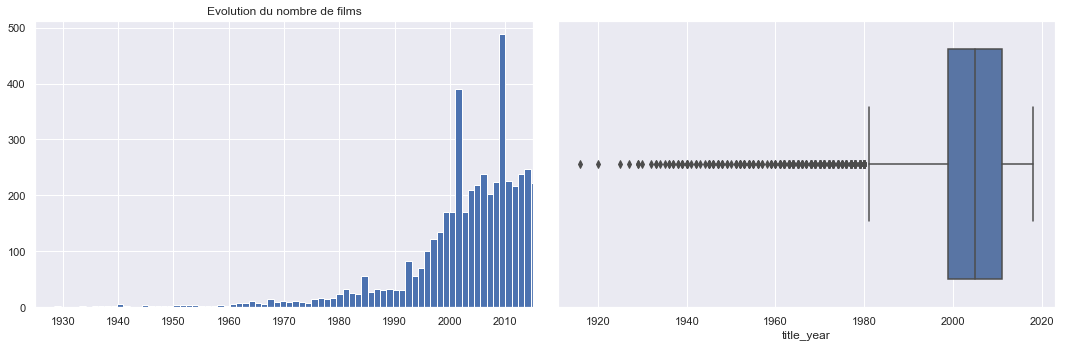

In [17]:
# Distribution des films dans le temps:

plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(data['title_year'], bins = 90)
plt.title('Evolution du nombre de films')
plt.xlim([1925,2015]) # Not displaying current year - data not fully added

plt.subplot(1,2,2)
sns.boxplot(data['title_year'])

plt.tight_layout()
plt.show()

# ==> de plus en plus de films au fil des ans

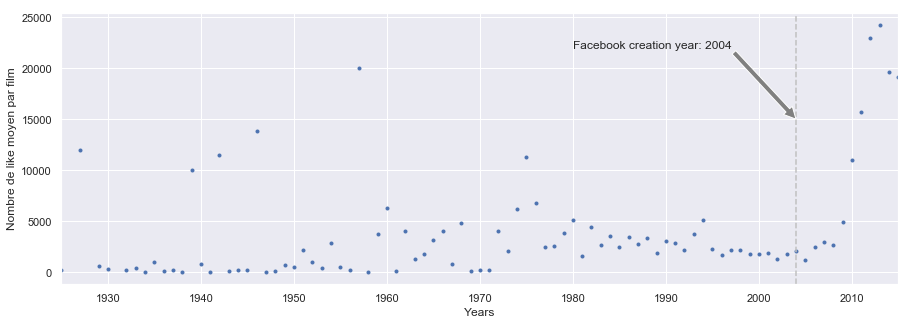

In [18]:
# New variable: the mean number of likes per movie / per year

df = data[['title_year','movie_facebook_likes']].groupby('title_year').agg('mean').reset_index()
df.columns = ['title_year','mean_movie_facebook_likes']
fig, ax = plt.subplots(figsize=(15,5))
# graphique:
ax.scatter(df['title_year'],
            df['mean_movie_facebook_likes'],
            marker='.')
ax.set_xlabel('Years')
ax.set_ylabel('Nombre de like moyen par film')
ax.set_xlim([1925,2015]) # Hiding current year 2016

# facebook creation year: axis
ax.axvline(2004, color='silver', ls='--')
# adding text and arrow:
ax.annotate('Facebook creation year: 2004', xy=(2004, 15000) , xytext=(1980, 22000), 
            arrowprops=dict(facecolor='grey', width=5))
plt.show()

In [19]:
# Les vieux films ont-ils autant de likes que les nouveaux? 
# --> Non à l'exception de quelques chefs d'oeuvre

# Valeurs inconsistantes dans le temps.
# Même raisonnement pour toutes les colonnes de 'likes' facebook.

In [20]:
# Suprression des colonnes de compteur de likes facebook:

L = ['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','director_facebook_likes',
     'movie_facebook_likes','cast_total_facebook_likes']
data = data.drop(L, axis=1)

data.shape

(4911, 19)

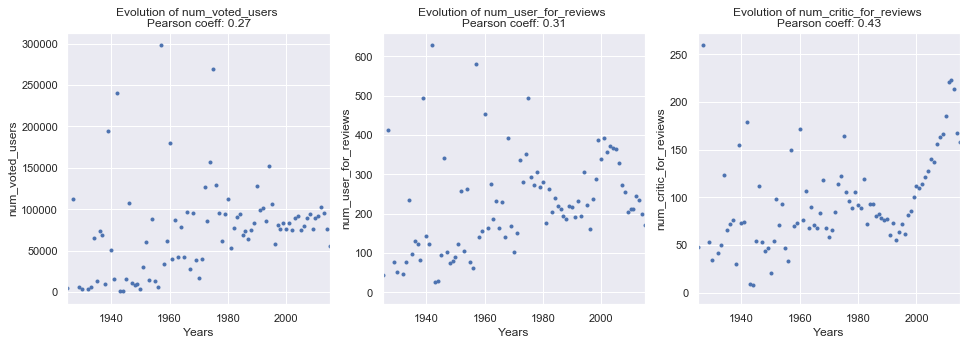

In [21]:
# Other similar features like facebook_likes: reviews or votes:

L = ['num_voted_users','num_user_for_reviews','num_critic_for_reviews']

plt.subplots(figsize=(16,5))
    
for i in range(1,4):
    plt.subplot(1,3,i)
    df = data[['title_year', L[i-1]]].groupby('title_year').agg('mean').reset_index()
    df.columns = ['title_year', L[i-1]]

    # Plot:
    plt.scatter(df['title_year'],
                df[L[i-1]],
                marker='.')
    plt.xlabel('Years')
    plt.ylabel(L[i-1])
    plt.title('Evolution of %s \nPearson coeff: %.2f'%(L[i-1],df.corr().iloc[0,1]))
    plt.xlim([1925,2015]) # Hiding current year
plt.show()

In [22]:
# Pour les memes raisons que les likes facebook on supprime ces champs.
# Cela dit on garde le nombre de votant, car sera utile pour pondéré l'IMDb score.

L = ['num_user_for_reviews','num_critic_for_reviews']
data = data.drop(L, axis=1)

data.shape

(4911, 17)

In [23]:
# Budget & Gross:

data['budget'].sort_values(ascending=False).head() # Beaucoup de valeurs aberrantes - problèmes de currency
data['budget'][data['budget'].isnull()].shape # 389 lignes vides
data['gross'].sort_values(ascending=False) # Pas de valeurs aberrantes à priori
data['gross'][data['gross'].isnull()].shape # 761 lignes vides

# Pour être utilisé: 'budget' et 'gross' devraient être corrigés:
#   - pour prendre en compte l'inflation chaque année
#   - pour afficher une monnaie unique, pas un mix d'euros, dollars, ancien francs, etc.

# Budget n'est pas un indicateur de similarité.
# Budget n'est pas un indicateur de succès d'un film.
# Gross est un indicateur de succès d'un film, mais redondant avec IMDb_score et certainement biaisé car cela dépend
# beaucoup de l'année de sortie, de l'exposition médiatique, du marketing, de la distribution locale/nationale/mondiale

data = data.drop(['budget','gross'], axis=1)

data.shape

(4911, 15)

In [24]:
# Réorganisation de l'ordre des champs:

data = data[['movie_id','movie_title','title_year','imdb_score','num_voted_users','color',
             'content_rating','language','country','director_name','actor_1_name',
             'actor_2_name','actor_3_name','genres','plot_keywords']]

In [25]:
# Nombre de lignes NaN:

data.shape[0]-data.count()

movie_id           0
movie_title        0
title_year         0
imdb_score         0
num_voted_users    0
color              0
content_rating     0
language           0
country            0
director_name      0
actor_1_name       0
actor_2_name       0
actor_3_name       0
genres             0
plot_keywords      0
dtype: int64

In [26]:
# Category variables:

L = ['content_rating','language','country','genres', 'plot_keywords',
     'actor_1_name','actor_2_name','actor_3_name','director_name']
data[L].nunique()

content_rating      17
language            47
country             65
genres             912
plot_keywords     4755
actor_1_name      2095
actor_2_name      3028
actor_3_name      3518
director_name     2397
dtype: int64

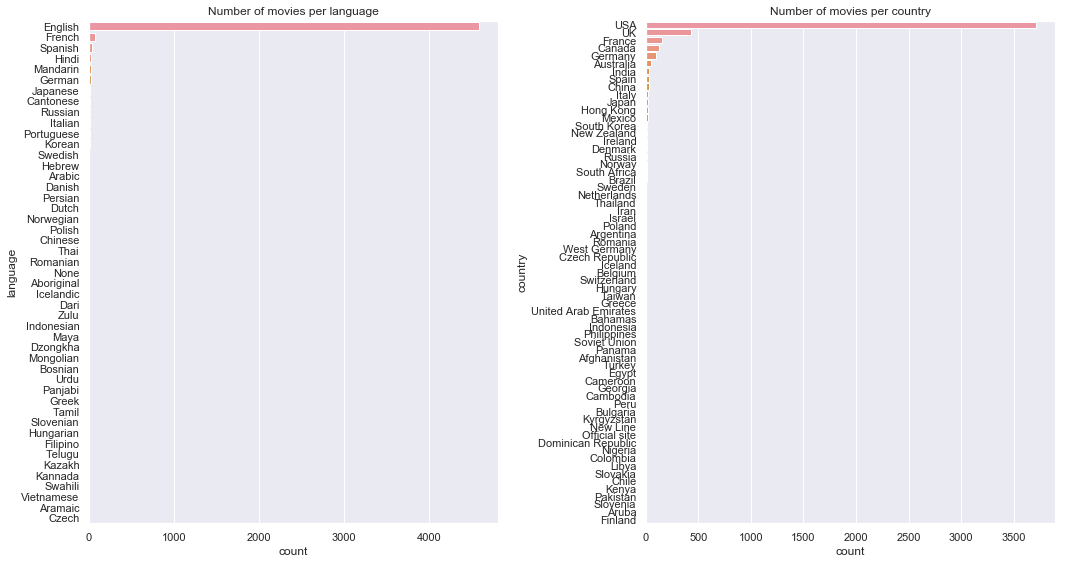

In [27]:
# COUNTRY & LANGUAGE:

plt.subplots(figsize=(15,8))

# Nombre de films par language:
plt.subplot(1,2,1)
df1 = data['language'].value_counts().reset_index()
df1.columns = ['language','count']
sns.barplot('count','language', data=df1, orient='h')
plt.title('Number of movies per language')


# Nombre de films par pays:
plt.subplot(1,2,2)
df2 = data['country'].value_counts().reset_index()
df2.columns = ['country','count']
sns.barplot('count','country', data=df2, orient='h')
plt.title('Number of movies per country')

plt.tight_layout()
plt.show()

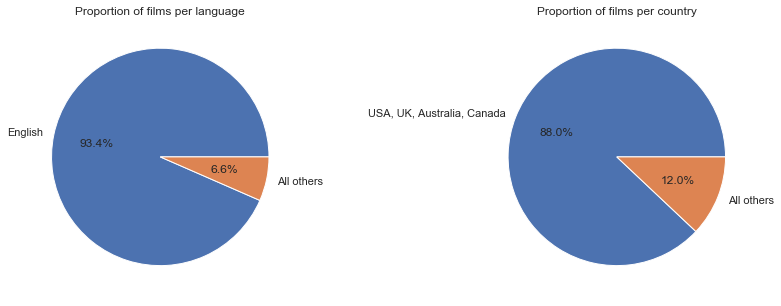

In [28]:
# Pie plot:
plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
df1 = data['language'].value_counts()
dtemp = pd.DataFrame()
dtemp.loc['English','films_n'] = df1['English']
dtemp.loc['All others','films_n'] = df1.sum() - df1['English']
plt.pie(dtemp, 
        labels=dtemp.index,
        autopct='%1.1f%%')
plt.title('Proportion of films per language')
plt.subplot(1,2,2)
df2 = data['country'].value_counts()
dtemp = pd.DataFrame()
dtemp.loc['USA, UK, Australia, Canada','films_n'] = df2['USA']+df2['UK']+df2['Canada']+df2['Australia']
dtemp.loc['All others','films_n'] = df2.sum() - (df2['USA']+df2['UK']+df2['Canada']+df2['Australia'])
plt.pie(dtemp, 
        labels=dtemp.index,
        autopct='%1.1f%%')
plt.title('Proportion of films per country')
plt.show()

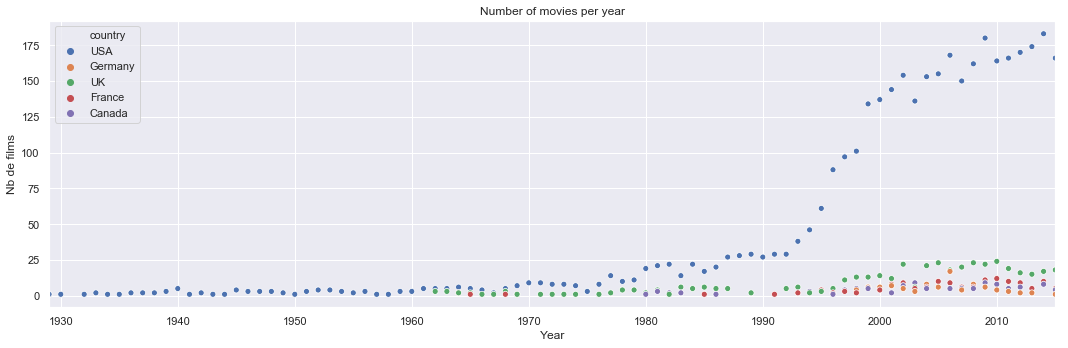

In [29]:
# Evolution of number of movies for the top 5 countries:

L = list(data['country'].value_counts()[:5].index) #top 5 countries
df = data[['title_year','country']][data['country'].isin(L)] #filtre countries
df.loc[:,'count'] = 1 #compteur
df = df.groupby(['title_year','country']).agg('sum').reset_index().sort_values(['title_year','count'], 
                                                                               ascending=[True, False])

plt.subplots(figsize=(15,5))
sns.scatterplot(x='title_year',
                y='count',
                hue='country',
                data=df)
plt.xlim([1929,2015]) #Hiding current year
plt.xlabel('Year')
plt.ylabel('Nb de films')
plt.title('Number of movies per year')
plt.tight_layout()
plt.show()

In [30]:
# Database VERY english oriented.

In [31]:
# GENRES:

data['genres'].head()

0    Action|Adventure|Fantasy|Sci-Fi
1           Action|Adventure|Fantasy
2          Action|Adventure|Thriller
3                    Action|Thriller
5            Action|Adventure|Sci-Fi
Name: genres, dtype: object

In [32]:
# Combien de genre de films au total:
L_temp = []
L_temp.extend(data['genres'].str.split('|'))
L_genres = []
for sublist in L_temp:
    L_genres.extend(sublist)
L_genres=list(set(L_genres))
print(len(L_genres))
np.array(L_genres)

26


array(['Comedy', 'Crime', 'Action', 'News', 'Reality-TV', 'Romance',
       'History', 'War', 'Adventure', 'Drama', 'Western', 'Family',
       'Mystery', 'Animation', 'Sci-Fi', 'Music', 'Film-Noir', 'Horror',
       'Thriller', 'Fantasy', 'Biography', 'Game-Show', 'Musical',
       'Documentary', 'Short', 'Sport'], dtype='<U11')

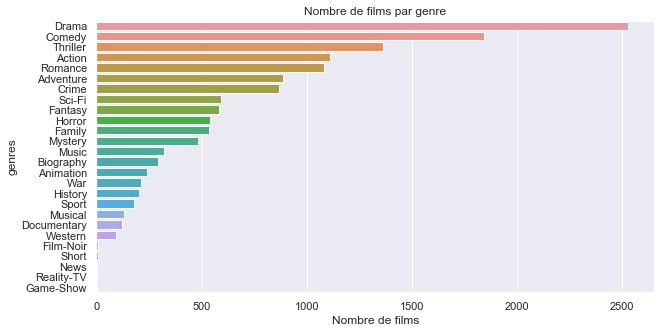

In [33]:
# Distribution des genres:

df = pd.DataFrame(index=L_genres, columns=['count'])
for i in L_genres:
    df.loc[i,'count'] = data['genres'][data['genres'].str.contains(i)].shape[0]
df = df.reset_index().sort_values('count', ascending=False)
df.columns = ['genres','count']

plt.subplots(figsize=(10,5))
sns.barplot(x='count', y='genres', data=df)
plt.xlabel('Nombre de films')
plt.title('Nombre de films par genre')
plt.show()

In [34]:
# Création d'un nouveau genre: Serie

data['genres'][data['director_name']==""] = data['genres'][data['director_name']==""] + "|Serie"
# Les 96 lignes ayant "director_name" vides sont des séries.

In [35]:
# PLOT_KEYWORDS

data['plot_keywords'].head()

0               avatar|future|marine|native|paraplegic
1    goddess|marriage ceremony|marriage proposal|pi...
2                  bomb|espionage|sequel|spy|terrorist
3    deception|imprisonment|lawlessness|police offi...
5    alien|american civil war|male nipple|mars|prin...
Name: plot_keywords, dtype: object

In [36]:
# Combien de mot-clefs y a t-il au total:

L_temp = []
L_temp.extend(data['plot_keywords'].str.split('|'))
L = []

for sublist in L_temp:
    L.extend(sublist)
tot_words = len(L) # nombre total de mots-clefs (duplicas inclus)
L=list(set(L))
tot_keywords = len(L) # nombre total de "mot-clefs unique"
print('mot-clefs au total (duplicata inclus):',tot_words)
print('mot-clefs au total (duplicata exclus):',tot_keywords)

mot-clefs au total (duplicata inclus): 23617
mot-clefs au total (duplicata exclus): 8078


In [37]:
# Distribution des mots-clef:

df1 = pd.DataFrame(index=L, columns=['count'])

dtemp = '|'+data['plot_keywords']+'|'  # Ajout de '|' en début et fin de cellule
# Pour éviter que des mots soient comptés dans d'autres: ex: 'ash' compté dans 'crash', 'flash', 'cash', etc.
for string in L:
    string = '|'+string+'|'
    df1.loc[string,'count'] = dtemp[(dtemp.str.contains(string, regex=False))].shape[0]

In [38]:
# Distribution des mots-clef:

df2 = df1.reset_index()
df2.columns = ['plot_keywords','count']
df2 = df2.sort_values('count', ascending=False)
df2.head(15).T

,15706,8455,12680,8078,8921,10004,13691,15372,14773,9566,9540,12728,12086,9077,15478
plot_keywords,|love|,|friend|,|murder|,||,|death|,|police|,|new york city|,|high school|,|alien|,|boy|,|school|,|revenge|,|fbi|,|friendship|,|drugs|
count,191,164,157,149,129,125,91,88,80,71,70,70,69,67,65


In [39]:
data.count()

movie_id           4911
movie_title        4911
title_year         4911
imdb_score         4911
num_voted_users    4911
color              4911
content_rating     4911
language           4911
country            4911
director_name      4911
actor_1_name       4911
actor_2_name       4911
actor_3_name       4911
genres             4911
plot_keywords      4911
dtype: int64

In [40]:
# Export des données nettoyées:

data.to_csv(os.getcwd()+'\\MovieDB_post_cleaning.csv')